In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import math

# Reading Foot_sensor Data


In [53]:
data = pd.read_csv('foot_sensor1.csv')
data['time_seconds'] = data['time_seconds'] = data.index * (1/120)
data['Acc_Z_derivative'] = np.gradient(data['Acc_Z'], data['time_seconds'])
print(data)

data.to_csv('foot_sensor_updated.csv', index=False)

      PacketCounter  SampleTimeFine    Euler_X    Euler_Y     Euler_Z  \
0                 0      2936795545   0.677420 -87.953209 -168.338425   
1                 1      2936803878   0.729427 -87.952835 -168.386215   
2                 2      2936812211   0.722955 -87.953491 -168.376251   
3                 3      2936820544   0.736462 -87.954269 -168.385742   
4                 4      2936828877   0.680547 -87.955605 -168.325867   
...             ...             ...        ...        ...         ...   
1719           1719      2951119972  20.947895 -52.262531 -139.799118   
1720           1720      2951128305  19.910072 -50.037071 -137.012207   
1721           1721      2951136638  19.042936 -47.715336 -134.320465   
1722           1722      2951144971  18.340414 -45.323582 -131.699615   
1723           1723      2951153304  17.816271 -42.916988 -129.146729   

          Acc_X     Acc_Y     Acc_Z       Gyr_X       Gyr_Y       Gyr_Z  \
0      0.000000  0.000000  0.000000    0.000000 

# Plotting Foot sensor data for visualisation 

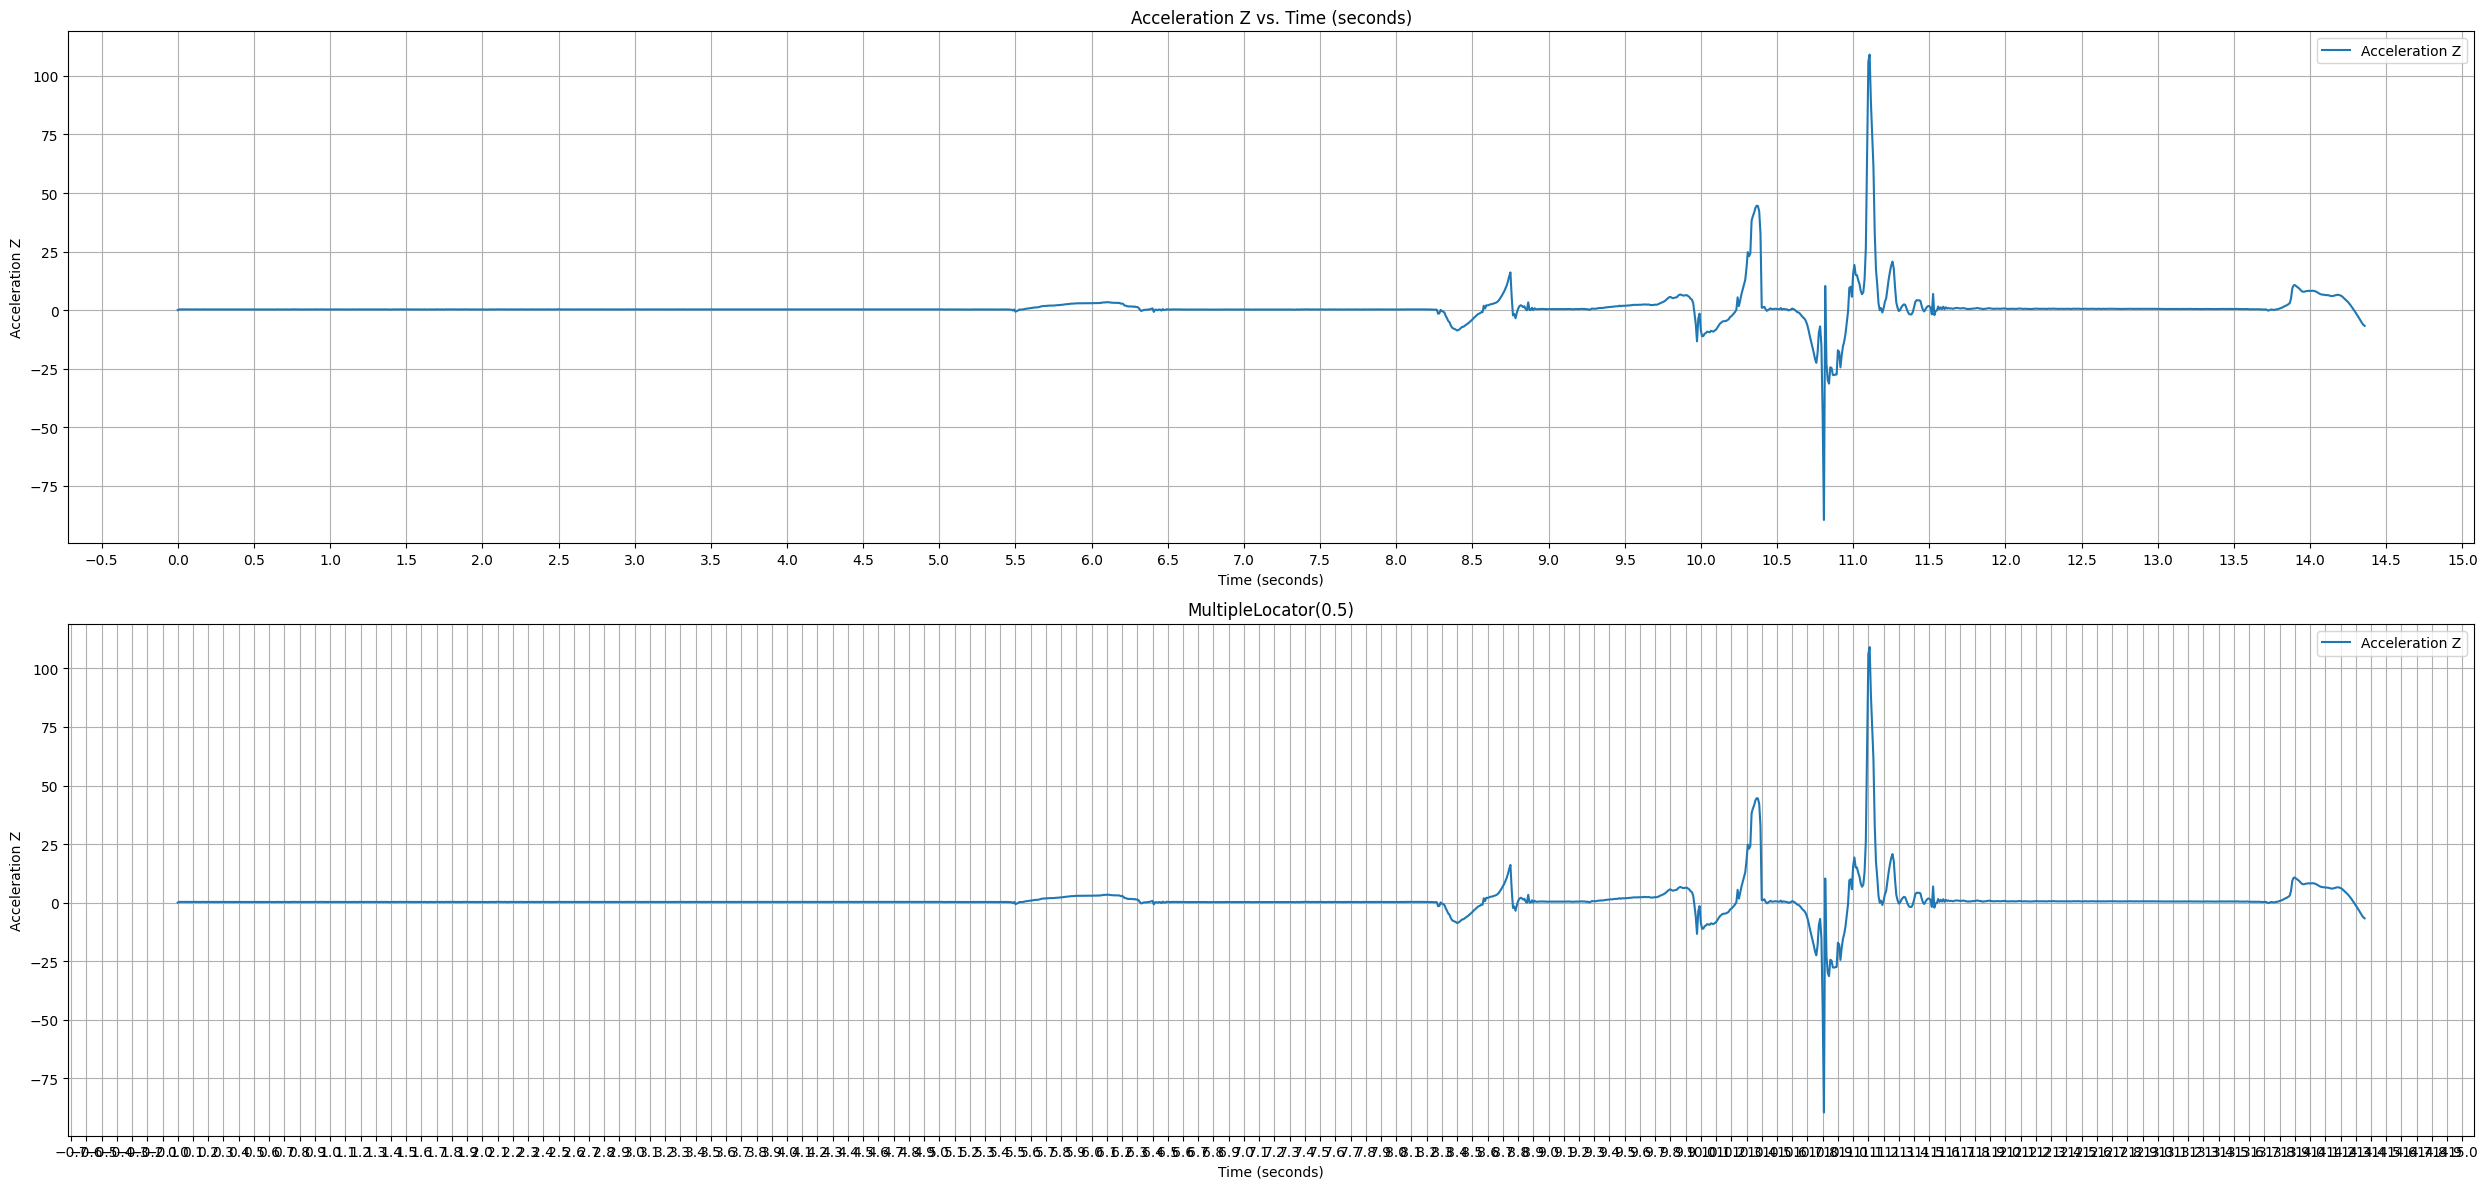

In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, axs = plt.subplots(2, 1, figsize=(25, 12))

# Plotting on the first subplot
axs[0].plot(data['time_seconds'], data['Acc_Z'], label='Acceleration Z')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Acceleration Z')
axs[0].set_title('MultipleLocator(0.5)')
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
axs[0].set_title('Acceleration Z vs. Time (seconds)')


axs[0].legend()
axs[0].grid(True)

# Setting up the second subplot with specific x-axis locators
axs[1].plot(data['time_seconds'], data['Acc_Z'], label='Acceleration Z')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Acceleration Z')
axs[1].set_title('MultipleLocator(0.5)')
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(0.1))
axs[1].xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


##### Visual Conclusion of start time for IMU sensor is 5.6-5.65

## Using Derivative of acceleration to find the start time for IMU sensor recording 



In [55]:

# Compute the derivative of Acc_Z with respect to time
data['Acc_Z_derivative'] = np.gradient(data['Acc_Z'], data['time_seconds'])

# Compute the change in the gradient (difference between consecutive values)
data['change_in_gradient'] = np.diff(data['Acc_Z_derivative'], prepend=data['Acc_Z_derivative'][0])

# Define the threshold
threshold = 10

# Create a mask for points where the change in gradient exceeds the threshold
mask = np.abs(data['change_in_gradient']) > threshold

# Skip the first 50 points for the mask and the corresponding results
skip_points = 50

# Adjust mask to skip the first 50 points
adjusted_mask = np.zeros_like(mask, dtype=bool)
adjusted_mask[skip_points:] = mask[skip_points:]

# Extract the points where the change in gradient is greater than the threshold
time_seconds_high_change = data['time_seconds'][adjusted_mask]
acc_z_high_change = data['Acc_Z'][adjusted_mask]
change_in_gradient_high_change = data['change_in_gradient'][adjusted_mask]

top_10_count = 10
time_seconds_top_10 = time_seconds_high_change.head(top_10_count)
acc_z_top_10 = acc_z_high_change.head(top_10_count)
change_in_gradient_top_10 = change_in_gradient_high_change.head(top_10_count)

# Find the index of the maximum change in gradient among these 10 values
max_change_index = change_in_gradient_top_10.abs().idxmax()

# Retrieve the corresponding time for the maximum change in gradient
max_time = time_seconds_top_10.loc[max_change_index]
max_change = change_in_gradient_top_10.loc[max_change_index]

# Display the results
print("Top 10 changes in gradient (excluding the first 50 points):")
for t, acc, change in zip(time_seconds_top_10, acc_z_top_10, change_in_gradient_top_10):
    print(f"Time: {t:.2f} s, Acceleration Z: {acc:.2f}, Change in Gradient: {change:.2f}")

print(f"\nAbsolute maximum change in gradient: {max_change:.2f} at Time: {max_time:.2f} s")

Top 10 changes in gradient (excluding the first 50 points):
Time: 5.47 s, Acceleration Z: 0.15, Change in Gradient: -17.30
Time: 5.48 s, Acceleration Z: -0.18, Change in Gradient: 31.00
Time: 5.49 s, Acceleration Z: 0.27, Change in Gradient: -37.53
Time: 5.50 s, Acceleration Z: -0.68, Change in Gradient: -12.40
Time: 5.51 s, Acceleration Z: -0.43, Change in Gradient: 71.90
Time: 5.52 s, Acceleration Z: -0.19, Change in Gradient: 10.52
Time: 5.53 s, Acceleration Z: 0.23, Change in Gradient: -17.85
Time: 5.53 s, Acceleration Z: 0.18, Change in Gradient: -23.58
Time: 6.07 s, Acceleration Z: 3.14, Change in Gradient: 12.30
Time: 6.08 s, Acceleration Z: 3.27, Change in Gradient: -10.19

Absolute maximum change in gradient: 71.90 at Time: 5.51 s


# Cleaning of Bowl Arm sensor Data 


In [56]:
Bowling_arm = pd.read_csv('Bowling_arm.csv')
print(Bowling_arm)
Bowling_arm['time_seconds'] = Bowling_arm.index * (1/120)
Bowling_arm_filtered = Bowling_arm[Bowling_arm['time_seconds'] >= max_time]
Bowling_arm_filtered = Bowling_arm_filtered.reset_index(drop=True)
Bowling_arm_filtered['time_seconds'] = Bowling_arm_filtered.index * (1/120)

Bowling_arm_filtered = Bowling_arm_filtered.loc[:, ~Bowling_arm_filtered.columns.str.contains('^Unnamed')]
Bowling_arm_filtered = Bowling_arm_filtered.drop(['PacketCounter', 'SampleTimeFine'], axis=1)


print(Bowling_arm_filtered)
Bowling_arm_filtered.to_csv('bowling_arm_filtered.csv', index=False)

      PacketCounter  SampleTimeFine     Euler_X    Euler_Y    Euler_Z  \
0                 0      2936853876 -151.631287   6.130547  31.782551   
1                 1      2936862209 -151.737167   5.774385  31.894129   
2                 2      2936870542 -151.891708   5.414848  32.024429   
3                 3      2936878875 -152.018890   5.070386  32.140991   
4                 4      2936887208 -152.186249   4.730982  32.229942   
...             ...             ...         ...        ...        ...   
1712           1712      2951119972  -63.149811 -42.699490   4.931848   
1713           1713      2951128305  -63.792336 -41.596046   6.121403   
1714           1714      2951136638  -64.363396 -40.542526   7.326623   
1715           1715      2951144971  -64.903084 -39.527771   8.564814   
1716           1716      2951153304  -65.381744 -38.571587   9.808268   

          Acc_X     Acc_Y     Acc_Z      Gyr_X      Gyr_Y       Gyr_Z  \
0      0.000000  0.000000  0.000000   0.000000   0

In [57]:

vicon_data = pd.read_csv('Actual_P4_01.csv')
print(vicon_data)
vicon_data.rename(columns={'X': 'Rcar_X', 'Y': 'Rcar_Y', 'Z': 'Rcar_Z'}, inplace=True)
min_length = min(len(Bowling_arm_filtered), len(vicon_data))
Bowling_arm_filtered = Bowling_arm_filtered.iloc[:min_length].reset_index(drop=True)
vicon_data = vicon_data.iloc[:min_length].reset_index(drop=True)
Bowling_arm_filtered = pd.concat([Bowling_arm_filtered, vicon_data[['Rcar_X', 'Rcar_Y', 'Rcar_Z']]], axis=1)
print(Bowling_arm_filtered)
Bowling_arm_filtered.to_csv('bowling_arm_filtered.csv', index=False)

Bowling_arm_filtered['Rcar_X'] = Bowling_arm_filtered['Rcar_X'] - Bowling_arm_filtered['Rcar_X'].iloc[0]
Bowling_arm_filtered['Rcar_Y'] = Bowling_arm_filtered['Rcar_Y'] - Bowling_arm_filtered['Rcar_Y'].iloc[0]
Bowling_arm_filtered['Rcar_Z'] = Bowling_arm_filtered['Rcar_Z'] - Bowling_arm_filtered['Rcar_Z'].iloc[0]
print(Bowling_arm_filtered)
Bowling_arm_filtered.to_csv('bowling_arm_filtered.csv', index=False)

               X            Y            Z      time
0    -956.595642  4138.782227  1046.005859  0.000000
1    -957.950195  4138.534668  1048.374634  0.008333
2    -958.924988  4138.032227  1050.314819  0.016667
3    -959.946411  4137.620117  1052.264404  0.025000
4    -960.885071  4137.353027  1053.942749  0.033333
...          ...          ...          ...       ...
998  -364.087799  1551.262573   863.862915  8.316667
999  -360.573151  1575.396362   866.520203  8.325000
1000 -357.478058  1599.299072   869.561890  8.333333
1001 -355.050812  1623.163086   872.793823  8.341667
1002 -352.949188  1646.765137   876.320496  8.350000

[1003 rows x 4 columns]
         Euler_X    Euler_Y     Euler_Z      Acc_X     Acc_Y     Acc_Z  \
0    -134.571304   8.095066   18.445393  -1.038877 -7.562953 -7.330730   
1    -134.533142   8.013421   18.457180  -1.026736 -7.719769 -7.374854   
2    -134.485931   7.937060   18.477118  -0.996035 -7.657115 -7.283552   
3    -134.432892   7.863248   18.504539  -0

## Filtering Out Noise in Acceleration Data Using a Pass Filter

- **Objective:** Filter out noise from acceleration data to obtain accurate results.
- **Filter Types:**
  - **High Pass Filter:**
    - **Purpose:** Removes low-frequency noise and retains high-frequency signals.
    - **Application:** Useful if noise predominantly consists of low-frequency components.
  - **Low Pass Filter:**
    - **Purpose:** Removes high-frequency noise and retains low-frequency signals.
    - **Application:** Useful if noise predominantly consists of high-frequency components.
- **Approach:**
  - **Pre-Trials:** Determined that a high pass filter might be more effective.
  - **Testing:** Plan to try both high pass and low pass filters to compare their performance.
- **Goal:** Identify which filter provides the more accurate results



#### Euler Rotation

In [58]:
def euler_to_rotation_matrix(roll, pitch, yaw):
    roll, pitch, yaw = np.radians([roll, pitch, yaw])
    
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])

    Ry = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])

    Rz = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])

    R = Rz @ Ry @ Rx
    return R

In [59]:
def gravity_vector_in_sensor_frame(roll, pitch, yaw):
    g = 9.81 
    g_global = np.array([0, 0, -g])
    R = euler_to_rotation_matrix(roll, pitch, yaw)
    g_sensor = R.T @ g_global  
    return g_sensor

In [60]:
def convert_and_correct_acceleration(acc_x, acc_y, acc_z, roll, pitch, yaw):
    R = euler_to_rotation_matrix(roll, pitch, yaw)
    g_sensor = gravity_vector_in_sensor_frame(roll, pitch, yaw)
    acceleration_sensor_frame = np.array([acc_x, acc_y, acc_z])
    acceleration_corrected = acceleration_sensor_frame - g_sensor
    acceleration_global = R @ acceleration_corrected
    return acceleration_global

In [61]:
from scipy.integrate import cumulative_trapezoid as cumtrapz

def apply_conversion(row):
    acc_x, acc_y, acc_z = row['Acc_X'], row['Acc_Y'], row['Acc_Z']
    roll, pitch, yaw = row['Euler_X'], row['Euler_Y'], row['Euler_Z']
    return pd.Series(convert_and_correct_acceleration(acc_x, acc_y, acc_z, roll, pitch, yaw),
                     index=['Acc_Global_X', 'Acc_Global_Y', 'Acc_Global_Z'])


In [62]:

Bowling_arm_filtered[['Acc_Global_X', 'Acc_Global_Y', 'Acc_Global_Z']] = Bowling_arm_filtered.apply(apply_conversion, axis=1)
Bowling_arm_filtered.to_csv('bowling_arm_filtered.csv', index=False)
print(Bowling_arm_filtered)

Bowling_arm_filtered[['Acc_Global_X', 'Acc_Global_Y', 'Acc_Global_Z']] = Bowling_arm_filtered.apply(apply_conversion, axis=1)

# Calculate velocity
time = Bowling_arm_filtered['time_seconds'].values
acc_x_global = Bowling_arm_filtered['Acc_Global_X'].values
acc_y_global = Bowling_arm_filtered['Acc_Global_Y'].values
acc_z_global = Bowling_arm_filtered['Acc_Global_Z'].values

vel_x = cumtrapz(acc_x_global, time, initial=0)
vel_y = cumtrapz(acc_y_global, time, initial=0)
vel_z = cumtrapz(acc_z_global, time, initial=0)

# Add velocity columns to the DataFrame
Bowling_arm_filtered['Vel_X'] = vel_x
Bowling_arm_filtered['Vel_Y'] = vel_y
Bowling_arm_filtered['Vel_Z'] = vel_z

# Save the updated DataFrame to a CSV file
Bowling_arm_filtered.to_csv('bowling_arm_filtered.csv', index=False)

print(Bowling_arm_filtered.head())

         Euler_X    Euler_Y     Euler_Z      Acc_X     Acc_Y     Acc_Z  \
0    -134.571304   8.095066   18.445393  -1.038877 -7.562953 -7.330730   
1    -134.533142   8.013421   18.457180  -1.026736 -7.719769 -7.374854   
2    -134.485931   7.937060   18.477118  -0.996035 -7.657115 -7.283552   
3    -134.432892   7.863248   18.504539  -0.929586 -7.478734 -7.259945   
4    -134.379257   7.793884   18.533216  -0.946726 -7.347108 -7.271055   
...          ...        ...         ...        ...       ...       ...   
998   142.754257 -48.245483  165.280853  10.757022 -6.217857  1.681316   
999   143.065720 -47.348465  166.251785  10.769593 -6.193506  1.520631   
1000  143.402679 -46.611588  167.306732  10.807775 -6.119656  1.331092   
1001  143.768723 -46.043159  168.427078  10.833111 -5.947985  1.167717   
1002  144.158920 -45.663509  169.599457  10.922283 -5.735484  0.997292   

           Gyr_X      Gyr_Y       Gyr_Z  time_seconds      Rcar_X  \
0       5.917619   5.608480   -8.818880   

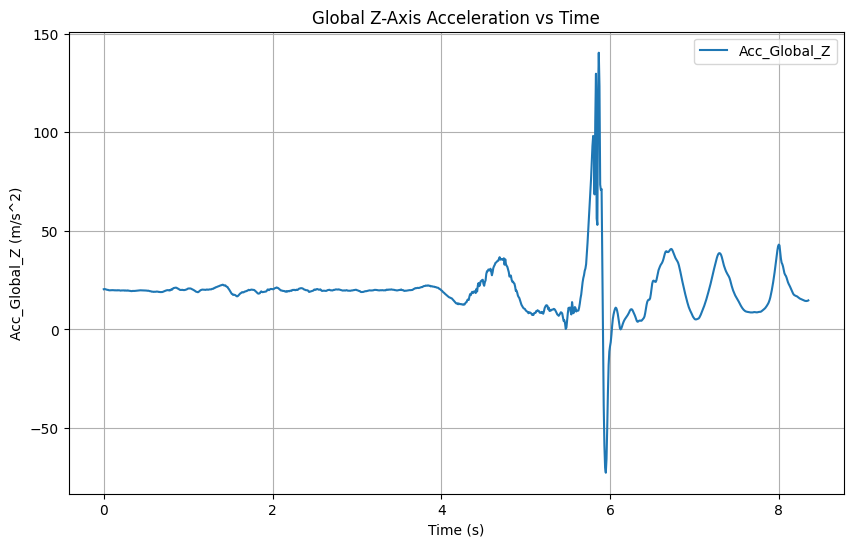

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(Bowling_arm_filtered['time_seconds'], Bowling_arm_filtered['Acc_Global_Z'], label='Acc_Global_Z')
plt.xlabel('Time (s)')
plt.ylabel('Acc_Global_Z (m/s^2)')
plt.title('Global Z-Axis Acceleration vs Time')
plt.legend()
plt.grid(True)
plt.show()

Euler_X         float64
Euler_Y         float64
Euler_Z         float64
Acc_X           float64
Acc_Y           float64
Acc_Z           float64
Gyr_X           float64
Gyr_Y           float64
Gyr_Z           float64
time_seconds    float64
Rcar_X          float64
Rcar_Y          float64
Rcar_Z          float64
Acc_Global_X    float64
Acc_Global_Y    float64
Acc_Global_Z    float64
Vel_X           float64
Vel_Y           float64
Vel_Z           float64
dtype: object
      Euler_X   Euler_Y    Euler_Z     Acc_X     Acc_Y     Acc_Z     Gyr_X  \
0 -134.571304  8.095066  18.445393 -1.038877 -7.562953 -7.330730  5.917619   
1 -134.533142  8.013421  18.457180 -1.026736 -7.719769 -7.374854  6.026645   
2 -134.485931  7.937060  18.477118 -0.996035 -7.657115 -7.283552  6.966766   
3 -134.432892  7.863248  18.504539 -0.929586 -7.478734 -7.259945  7.559248   
4 -134.379257  7.793884  18.533216 -0.946726 -7.347108 -7.271055  7.597862   

      Gyr_Y     Gyr_Z  time_seconds    Rcar_X    Rcar_Y    Rc

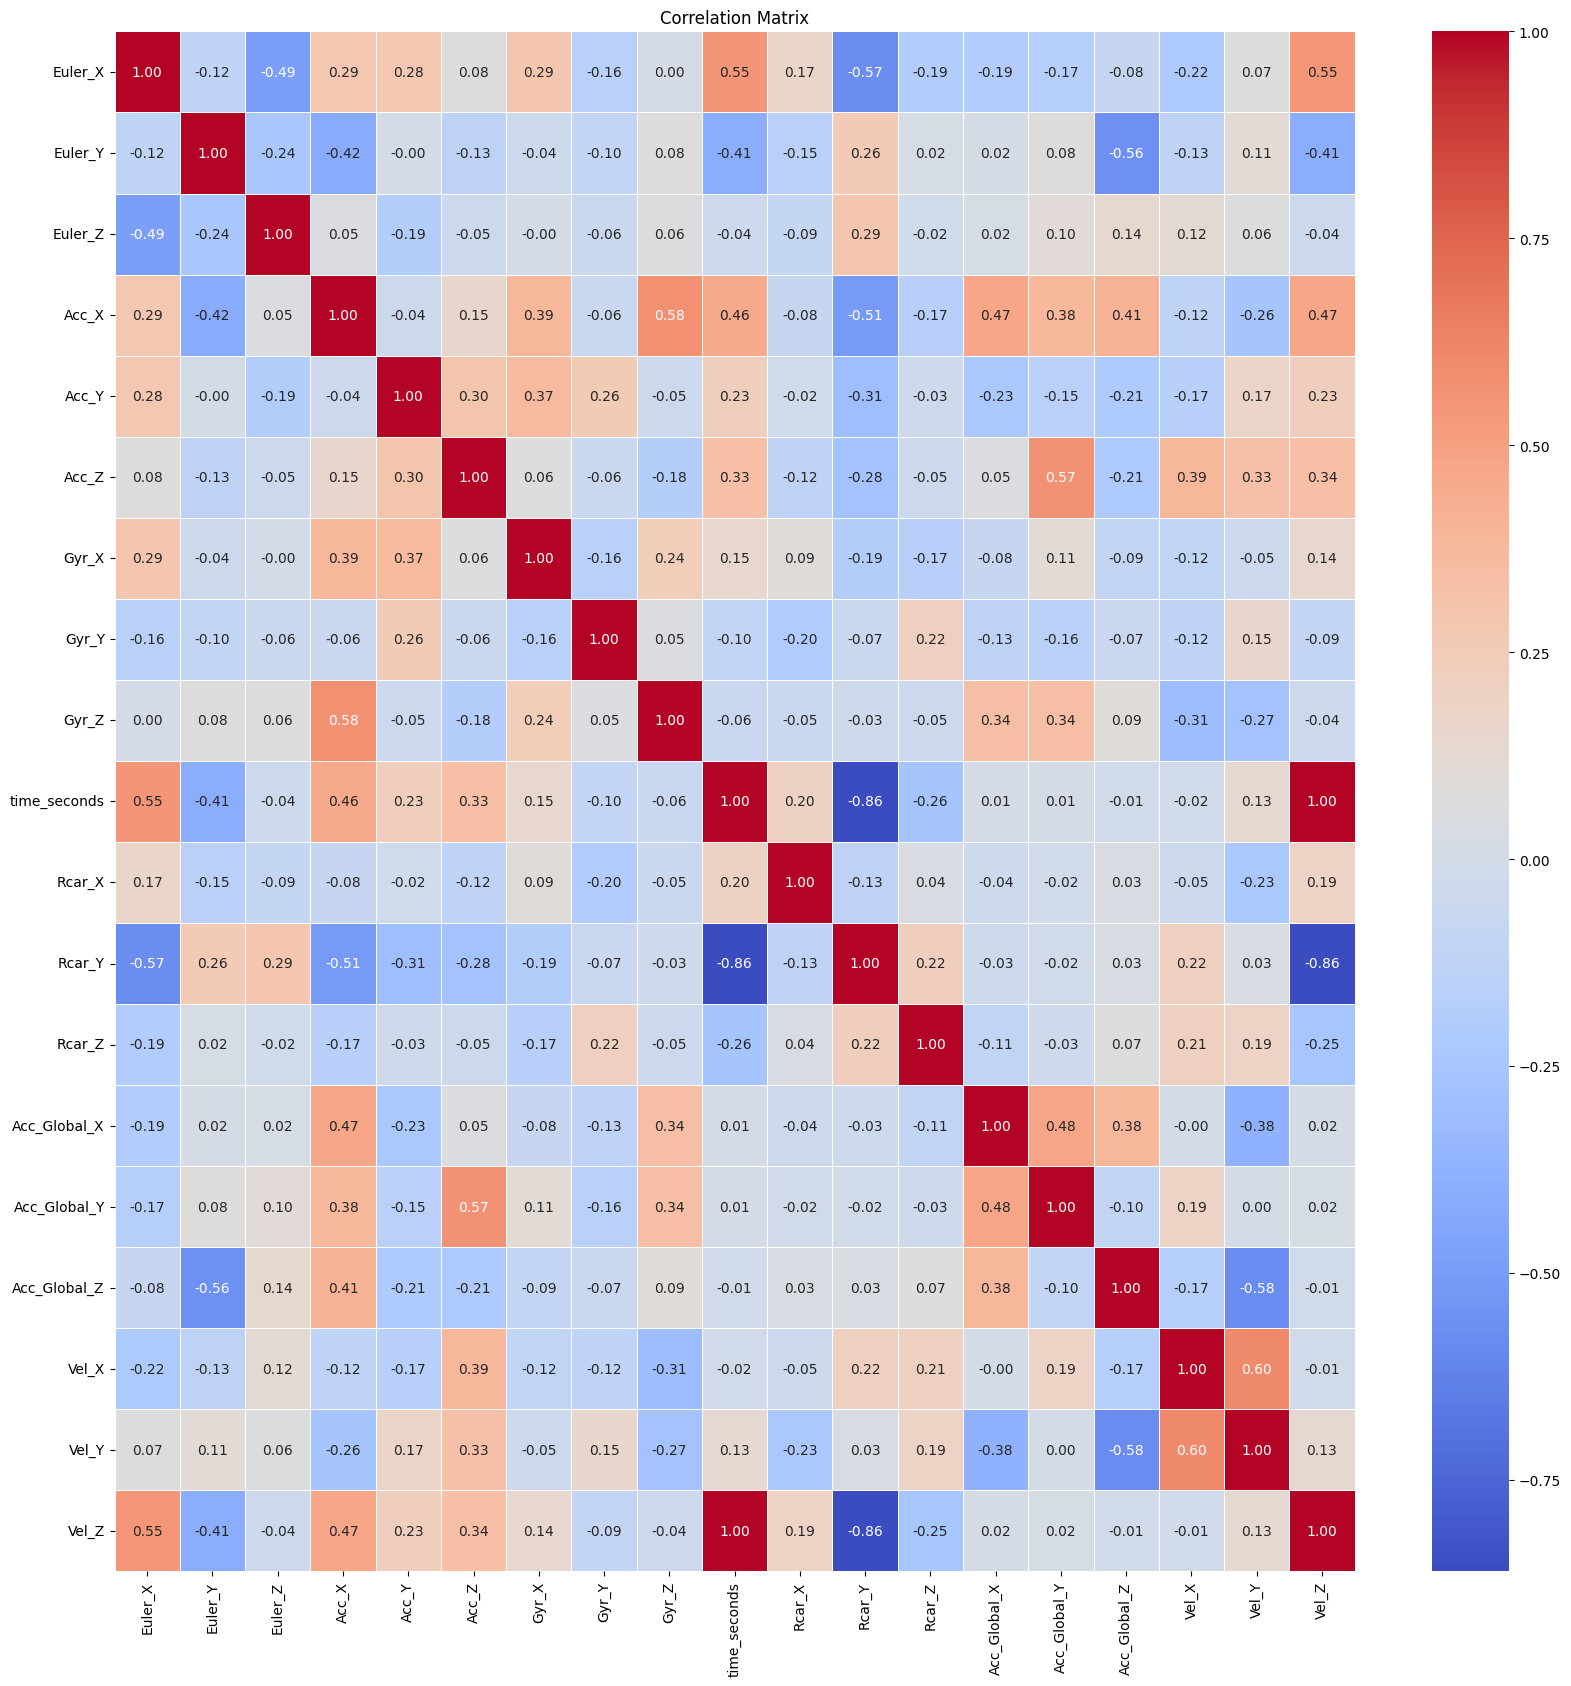

In [64]:
print(Bowling_arm_filtered.dtypes)
print(Bowling_arm_filtered.head())
corr_matrix = Bowling_arm_filtered.corr()
print(corr_matrix)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [65]:

# correlation_threshold = 0.1 

# low_correlation_cols = [col for col in corr_matrix.columns if abs(corr_matrix.loc[col, 'Rcar_Z']) < correlation_threshold and col != 'Rcar_Z']

# Bowling_arm_filtered_cleaned = Bowling_arm_filtered.drop(columns=low_correlation_cols)
# print(Bowling_arm_filtered_cleaned.head())
# corr_matrix_cleaned = Bowling_arm_filtered_cleaned.corr()
# print(corr_matrix_cleaned)
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix_cleaned, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Correlation Matrix (Filtered)')
# plt.show()


## Cleaning up and Preparing Test Set

In [66]:
data = pd.read_csv('foot_sensor2.csv')
data['time_seconds'] = data['time_seconds'] = data.index * (1/120)
data['Acc_Z_derivative'] = np.gradient(data['Acc_Z'], data['time_seconds'])
print(data)

data.to_csv('foot_sensor(P3_02)_updated.csv', index=False)

      PacketCounter  SampleTimeFine    Euler_X    Euler_Y     Euler_Z  \
0                 0      2978585540  20.885427 -87.512421 -165.910751   
1                 1      2978593873  20.819683 -87.516045 -165.840408   
2                 2      2978602206  20.810535 -87.515724 -165.827118   
3                 3      2978610539  20.726240 -87.517937 -165.738953   
4                 4      2978618872  20.685238 -87.519508 -165.693100   
...             ...             ...        ...        ...         ...   
1683           1683      2992609979  18.526228 -87.212029 -167.660339   
1684           1684      2992618312  19.990259 -87.213371 -169.139221   
1685           1685      2992626645  21.448486 -87.214211 -170.613388   
1686           1686      2992634978  22.893452 -87.217094 -172.072403   
1687           1687      2992643311  24.267527 -87.221733 -173.460480   

         Acc_X     Acc_Y     Acc_Z     Gyr_X     Gyr_Y     Gyr_Z Unnamed: 11  \
0     0.000000  0.000000  0.000000  0.00000

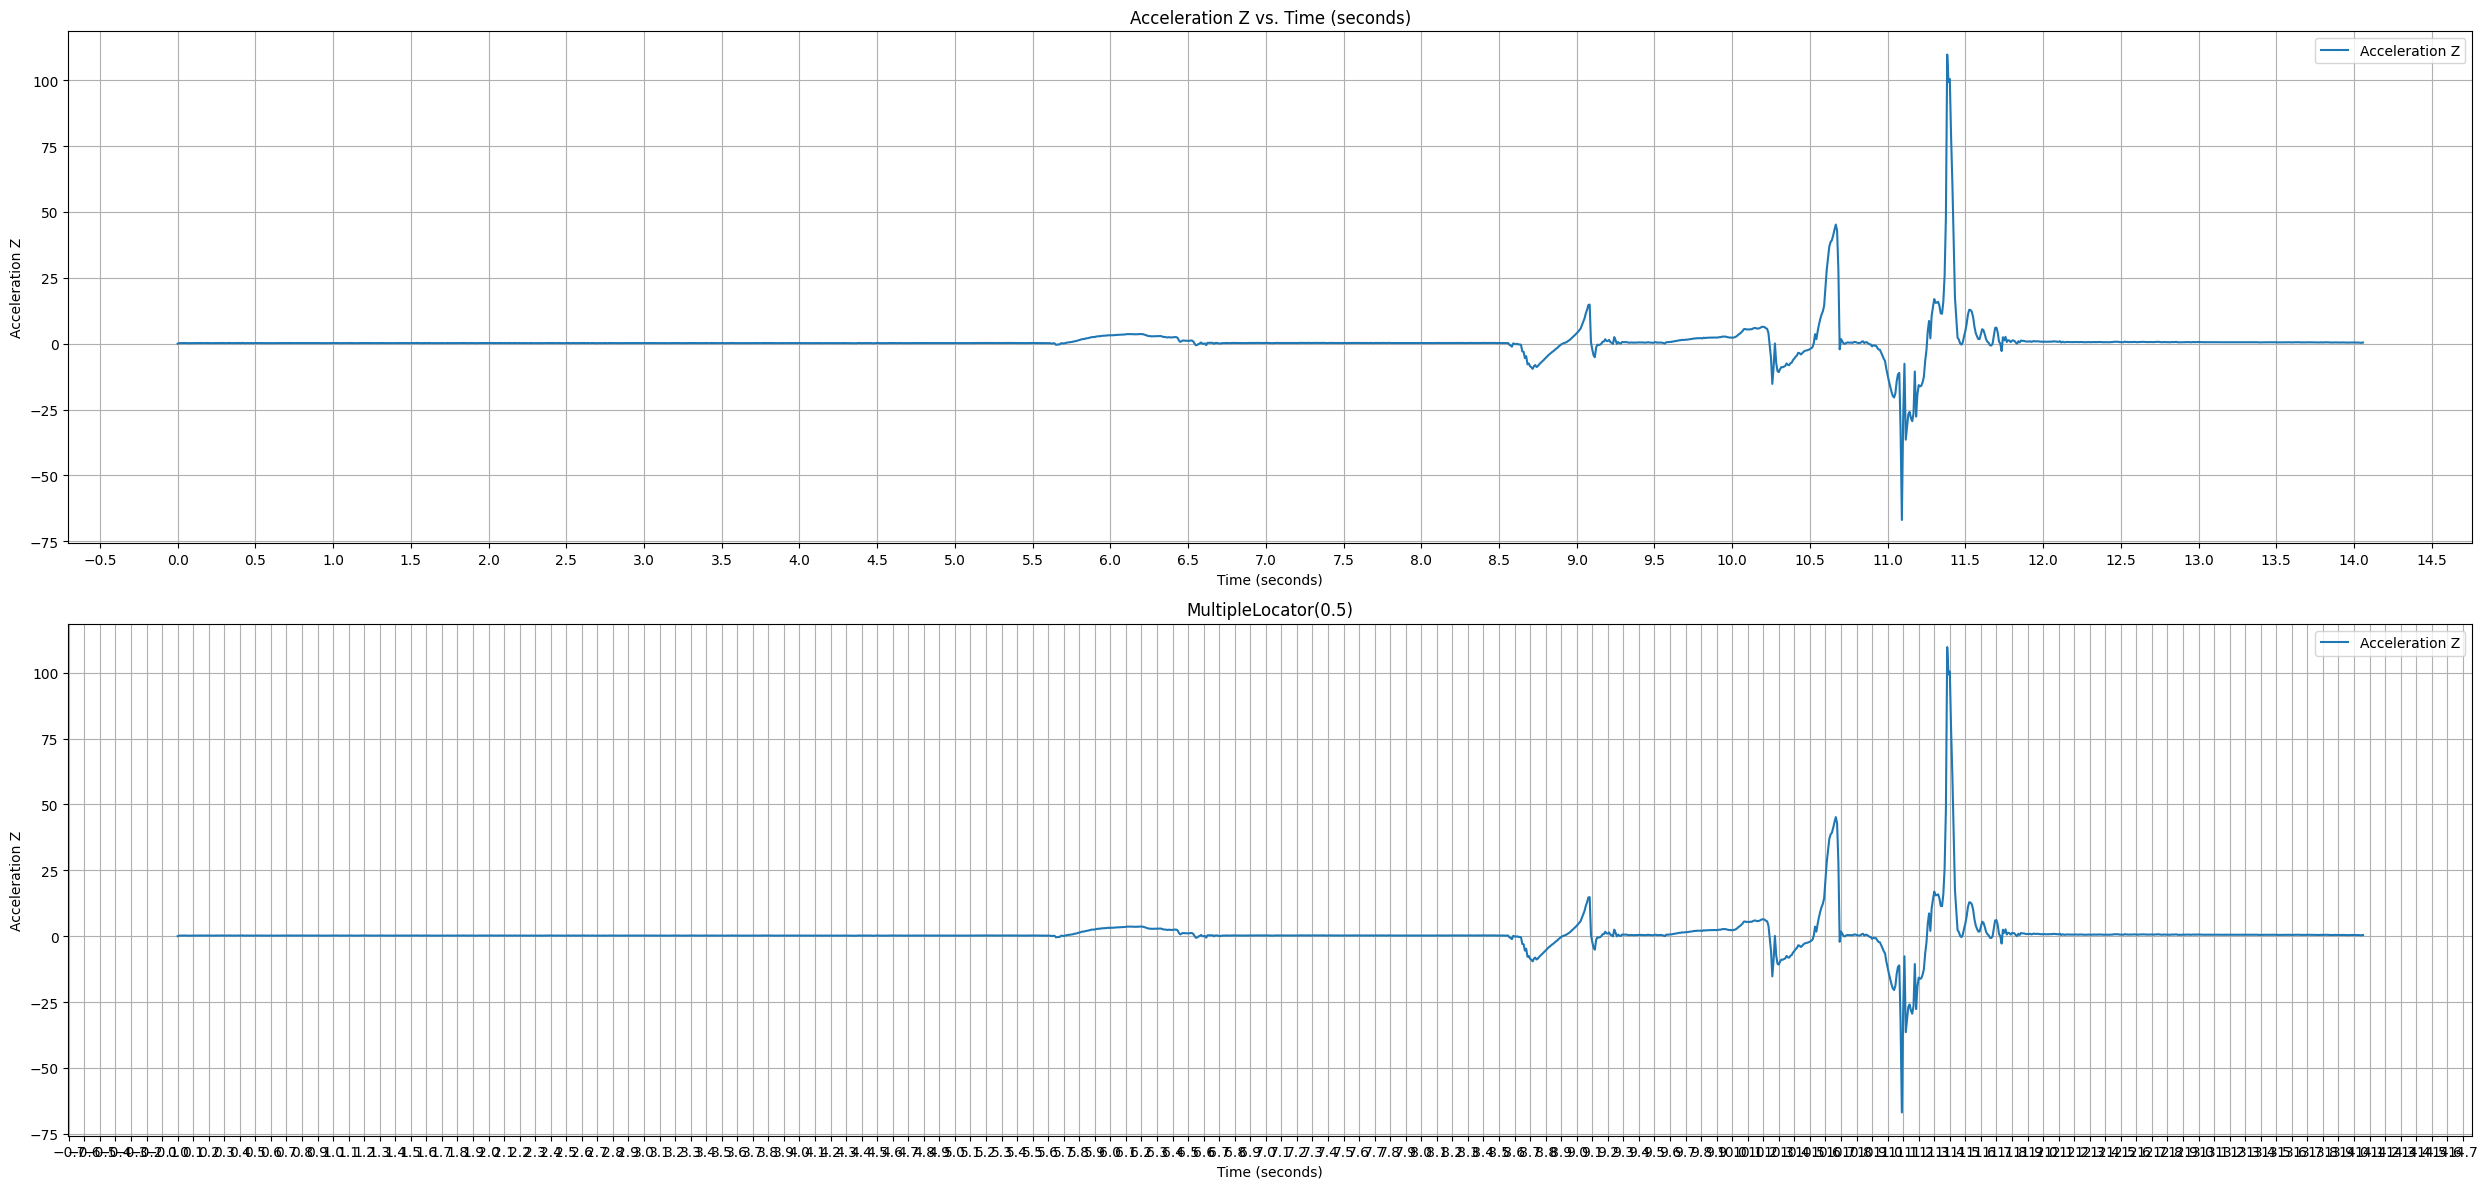

In [67]:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, axs = plt.subplots(2, 1, figsize=(25, 12))

# Plotting on the first subplot
axs[0].plot(data['time_seconds'], data['Acc_Z'], label='Acceleration Z')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Acceleration Z')
axs[0].set_title('MultipleLocator(0.5)')
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
axs[0].set_title('Acceleration Z vs. Time (seconds)')


axs[0].legend()
axs[0].grid(True)

# Setting up the second subplot with specific x-axis locators
axs[1].plot(data['time_seconds'], data['Acc_Z'], label='Acceleration Z')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Acceleration Z')
axs[1].set_title('MultipleLocator(0.5)')
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(0.1))
axs[1].xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [68]:
# Compute the derivative of Acc_Z with respect to time
data['Acc_Z_derivative'] = np.gradient(data['Acc_Z'], data['time_seconds'])

# Compute the change in the gradient (difference between consecutive values)
data['change_in_gradient'] = np.diff(data['Acc_Z_derivative'], prepend=data['Acc_Z_derivative'][0])

# Define the threshold
threshold = 10

# Create a mask for points where the change in gradient exceeds the threshold
mask = np.abs(data['change_in_gradient']) > threshold

# Skip the first 50 points for the mask and the corresponding results
skip_points = 50

# Adjust mask to skip the first 50 points
adjusted_mask = np.zeros_like(mask, dtype=bool)
adjusted_mask[skip_points:] = mask[skip_points:]

# Extract the points where the change in gradient is greater than the threshold
time_seconds_high_change = data['time_seconds'][adjusted_mask]
acc_z_high_change = data['Acc_Z'][adjusted_mask]
change_in_gradient_high_change = data['change_in_gradient'][adjusted_mask]

top_10_count = 10
time_seconds_top_10 = time_seconds_high_change.head(top_10_count)
acc_z_top_10 = acc_z_high_change.head(top_10_count)
change_in_gradient_top_10 = change_in_gradient_high_change.head(top_10_count)

# Find the index of the maximum change in gradient among these 10 values
max_change_index = change_in_gradient_top_10.abs().idxmax()

# Retrieve the corresponding time for the maximum change in gradient
max_time = time_seconds_top_10.loc[max_change_index]
max_change = change_in_gradient_top_10.loc[max_change_index]

# Display the results
print("Top 10 changes in gradient (excluding the first 50 points):")
for t, acc, change in zip(time_seconds_top_10, acc_z_top_10, change_in_gradient_top_10):
    print(f"Time: {t:.2f} s, Acceleration Z: {acc:.2f}, Change in Gradient: {change:.2f}")

print(f"\nAbsolute maximum change in gradient: {max_change:.2f} at Time: {max_time:.2f} s")


Top 10 changes in gradient (excluding the first 50 points):
Time: 4.47 s, Acceleration Z: 0.19, Change in Gradient: 10.28
Time: 5.62 s, Acceleration Z: 0.03, Change in Gradient: 12.68
Time: 5.64 s, Acceleration Z: 0.10, Change in Gradient: -40.80
Time: 5.66 s, Acceleration Z: -0.35, Change in Gradient: 35.56
Time: 5.67 s, Acceleration Z: -0.27, Change in Gradient: 23.62
Time: 5.69 s, Acceleration Z: 0.13, Change in Gradient: -30.45
Time: 5.70 s, Acceleration Z: 0.08, Change in Gradient: 13.04
Time: 5.90 s, Acceleration Z: 2.53, Change in Gradient: 10.98
Time: 6.33 s, Acceleration Z: 2.90, Change in Gradient: -16.06
Time: 6.34 s, Acceleration Z: 2.55, Change in Gradient: 11.05

Absolute maximum change in gradient: -40.80 at Time: 5.64 s


In [69]:

Bowling_arm2 = pd.read_csv('Bowling_arm2.csv')
print(Bowling_arm2)
Bowling_arm2['time_seconds'] = Bowling_arm2.index * (1/120)
Bowling_arm2_filtered = Bowling_arm2[Bowling_arm2['time_seconds'] >= max_time]
Bowling_arm2_filtered = Bowling_arm2_filtered.reset_index(drop=True)
Bowling_arm2_filtered['time_seconds'] = Bowling_arm2_filtered.index * (1/120)


Bowling_arm2_filtered = Bowling_arm2_filtered.loc[:, ~Bowling_arm2_filtered.columns.str.contains('^Unnamed')]
Bowling_arm2_filtered = Bowling_arm2_filtered.drop(['PacketCounter', 'SampleTimeFine'], axis=1)

print(Bowling_arm2_filtered)
Bowling_arm2_filtered.to_csv('Bowling_arm2_filtered.csv', index=False)


      PacketCounter  SampleTimeFine     Euler_X    Euler_Y     Euler_Z  \
0                 0      2978585540 -170.031891  -6.047856   28.011206   
1                 1      2978593873 -170.051773  -5.955964   27.959761   
2                 2      2978602206 -170.055435  -5.859836   27.908567   
3                 3      2978610539 -170.032776  -5.762128   27.859955   
4                 4      2978618872 -169.988220  -5.666813   27.808224   
...             ...             ...         ...        ...         ...   
1679           1679      2992576647  142.748810 -60.661083  161.872208   
1680           1680      2992584980  143.996994 -59.404179  160.157700   
1681           1681      2992593313  145.097427 -58.088856  158.691727   
1682           1682      2992601646  146.059586 -56.762486  157.459564   
1683           1683      2992609979  146.892975 -55.431782  156.465195   

          Acc_X     Acc_Y      Acc_Z      Gyr_X       Gyr_Y      Gyr_Z  \
0      0.000000  0.000000   0.000000 

In [70]:

vicon_data2 = pd.read_csv('Actual_P4_02.csv')
print(vicon_data2)

vicon_data2.rename(columns={'X': 'Rcar_X', 'Y': 'Rcar_Y', 'Z': 'Rcar_Z'}, inplace=True)

min_length = min(len(Bowling_arm2_filtered), len(vicon_data2))
Bowling_arm2_filtered = Bowling_arm2_filtered.iloc[:min_length].reset_index(drop=True)
vicon_data2 = vicon_data2.iloc[:min_length].reset_index(drop=True)

Bowling_arm2_filtered = pd.concat([Bowling_arm2_filtered, vicon_data2[['Rcar_X', 'Rcar_Y', 'Rcar_Z']]], axis=1)

print(Bowling_arm2_filtered)

Bowling_arm2_filtered.to_csv('Bowling_arm2_filtered.csv', index=False)
# Adjust Rcar_X, Rcar_Y, Rcar_Z to take the first point as zero
Bowling_arm2_filtered['Rcar_X'] = Bowling_arm2_filtered['Rcar_X'] - Bowling_arm2_filtered['Rcar_X'].iloc[0]
Bowling_arm2_filtered['Rcar_Y'] = Bowling_arm2_filtered['Rcar_Y'] - Bowling_arm2_filtered['Rcar_Y'].iloc[0]
Bowling_arm2_filtered['Rcar_Z'] = Bowling_arm2_filtered['Rcar_Z'] - Bowling_arm2_filtered['Rcar_Z'].iloc[0]

print(Bowling_arm2_filtered)

Bowling_arm2_filtered.to_csv('Bowling_arm2_filtered.csv', index=False)



               X            Y            Z      time
0    -935.412720  4065.837402  1044.782837  0.000000
1    -936.980530  4066.108154  1047.730347  0.008333
2    -938.323792  4066.295166  1050.486938  0.016667
3    -939.581970  4066.434326  1053.166138  0.025000
4    -940.789185  4066.405762  1055.832520  0.033333
..           ...          ...          ...       ...
965 -1069.420044   466.967377   883.973083  8.041667
966 -1058.749878   475.619019   879.146545  8.050000
967 -1047.737183   484.596527   874.303833  8.058333
968 -1036.308228   494.208221   869.375610  8.066667
969 -1024.483887   503.813629   864.638794  8.075000

[970 rows x 4 columns]
        Euler_X    Euler_Y    Euler_Z      Acc_X     Acc_Y     Acc_Z  \
0   -135.019180  12.959189  20.900089  -2.840319 -7.668686 -7.085876   
1   -135.056412  12.927301  20.914631  -2.743058 -7.479014 -7.140081   
2   -135.099457  12.902173  20.933754  -2.664557 -7.333792 -7.218023   
3   -135.147919  12.881481  20.951254  -2.608072 -7.

In [71]:

def apply_conversion(row):
    acc_x, acc_y, acc_z = row['Acc_X'], row['Acc_Y'], row['Acc_Z']
    roll, pitch, yaw = row['Euler_X'], row['Euler_Y'], row['Euler_Z']
    return pd.Series(convert_and_correct_acceleration(acc_x, acc_y, acc_z, roll, pitch, yaw),
                     index=['Acc_Global_X', 'Acc_Global_Y', 'Acc_Global_Z'])

Bowling_arm2_filtered[['Acc_Global_X', 'Acc_Global_Y', 'Acc_Global_Z']] = Bowling_arm2_filtered.apply(apply_conversion, axis=1)


Bowling_arm2_filtered.to_csv('Bowling_arm2_filtered.csv', index=False)
print(Bowling_arm2_filtered)


# Calculate velocity
time = Bowling_arm2_filtered['time_seconds'].values
acc_x_global = Bowling_arm2_filtered['Acc_Global_X'].values
acc_y_global = Bowling_arm2_filtered['Acc_Global_Y'].values
acc_z_global = Bowling_arm2_filtered['Acc_Global_Z'].values

vel_x = cumtrapz(acc_x_global, time, initial=0)
vel_y = cumtrapz(acc_y_global, time, initial=0)
vel_z = cumtrapz(acc_z_global, time, initial=0)

# Add velocity columns to the DataFrame
Bowling_arm2_filtered['Vel_X'] = vel_x
Bowling_arm2_filtered['Vel_Y'] = vel_y
Bowling_arm2_filtered['Vel_Z'] = vel_z

# Save the updated DataFrame to a CSV file
Bowling_arm2_filtered.to_csv('bowling_arm2_filtered.csv', index=False)


        Euler_X    Euler_Y    Euler_Z      Acc_X     Acc_Y     Acc_Z  \
0   -135.019180  12.959189  20.900089  -2.840319 -7.668686 -7.085876   
1   -135.056412  12.927301  20.914631  -2.743058 -7.479014 -7.140081   
2   -135.099457  12.902173  20.933754  -2.664557 -7.333792 -7.218023   
3   -135.147919  12.881481  20.951254  -2.608072 -7.456635 -7.281829   
4   -135.190659  12.862630  20.962811  -2.575241 -7.543605 -7.344702   
..          ...        ...        ...        ...       ...       ...   
965  -79.390297 -28.743639   5.448804  14.369938 -1.817325  0.704692   
966  -78.681625 -31.589575   5.111002  15.392938 -2.032222  0.913149   
967  -77.861961 -34.565037   4.762657  16.472815 -2.267493  1.163752   
968  -76.933861 -37.712284   4.408928  17.617809 -2.596982  1.393362   
969  -75.906578 -40.991642   4.065474  18.822929 -2.946536  1.587296   

         Gyr_X      Gyr_Y       Gyr_Z  time_seconds      Rcar_X       Rcar_Y  \
0    -4.649714   1.816050   -3.716485      0.000000    

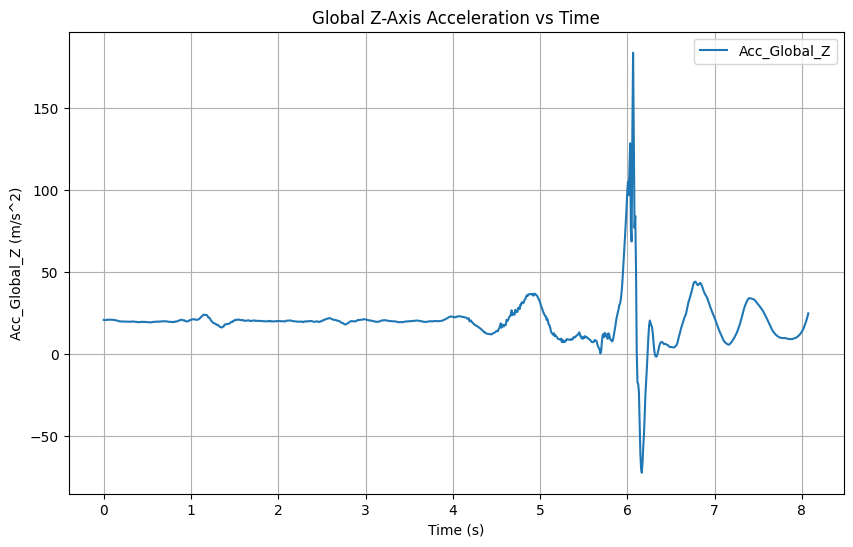

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(Bowling_arm2_filtered['time_seconds'], Bowling_arm2_filtered['Acc_Global_Z'], label='Acc_Global_Z')
plt.xlabel('Time (s)')
plt.ylabel('Acc_Global_Z (m/s^2)')
plt.title('Global Z-Axis Acceleration vs Time')
plt.legend()
plt.grid(True)
plt.show()

Euler_X         float64
Euler_Y         float64
Euler_Z         float64
Acc_X           float64
Acc_Y           float64
Acc_Z           float64
Gyr_X           float64
Gyr_Y           float64
Gyr_Z           float64
time_seconds    float64
Rcar_X          float64
Rcar_Y          float64
Rcar_Z          float64
Acc_Global_X    float64
Acc_Global_Y    float64
Acc_Global_Z    float64
Vel_X           float64
Vel_Y           float64
Vel_Z           float64
dtype: object
      Euler_X    Euler_Y    Euler_Z     Acc_X     Acc_Y     Acc_Z     Gyr_X  \
0 -135.019180  12.959189  20.900089 -2.840319 -7.668686 -7.085876 -4.649714   
1 -135.056412  12.927301  20.914631 -2.743058 -7.479014 -7.140081 -3.212128   
2 -135.099457  12.902173  20.933754 -2.664557 -7.333792 -7.218023 -3.856159   
3 -135.147919  12.881481  20.951254 -2.608072 -7.456635 -7.281829 -4.638009   
4 -135.190659  12.862630  20.962811 -2.575241 -7.543605 -7.344702 -3.617422   

      Gyr_Y     Gyr_Z  time_seconds    Rcar_X    Rcar_Y

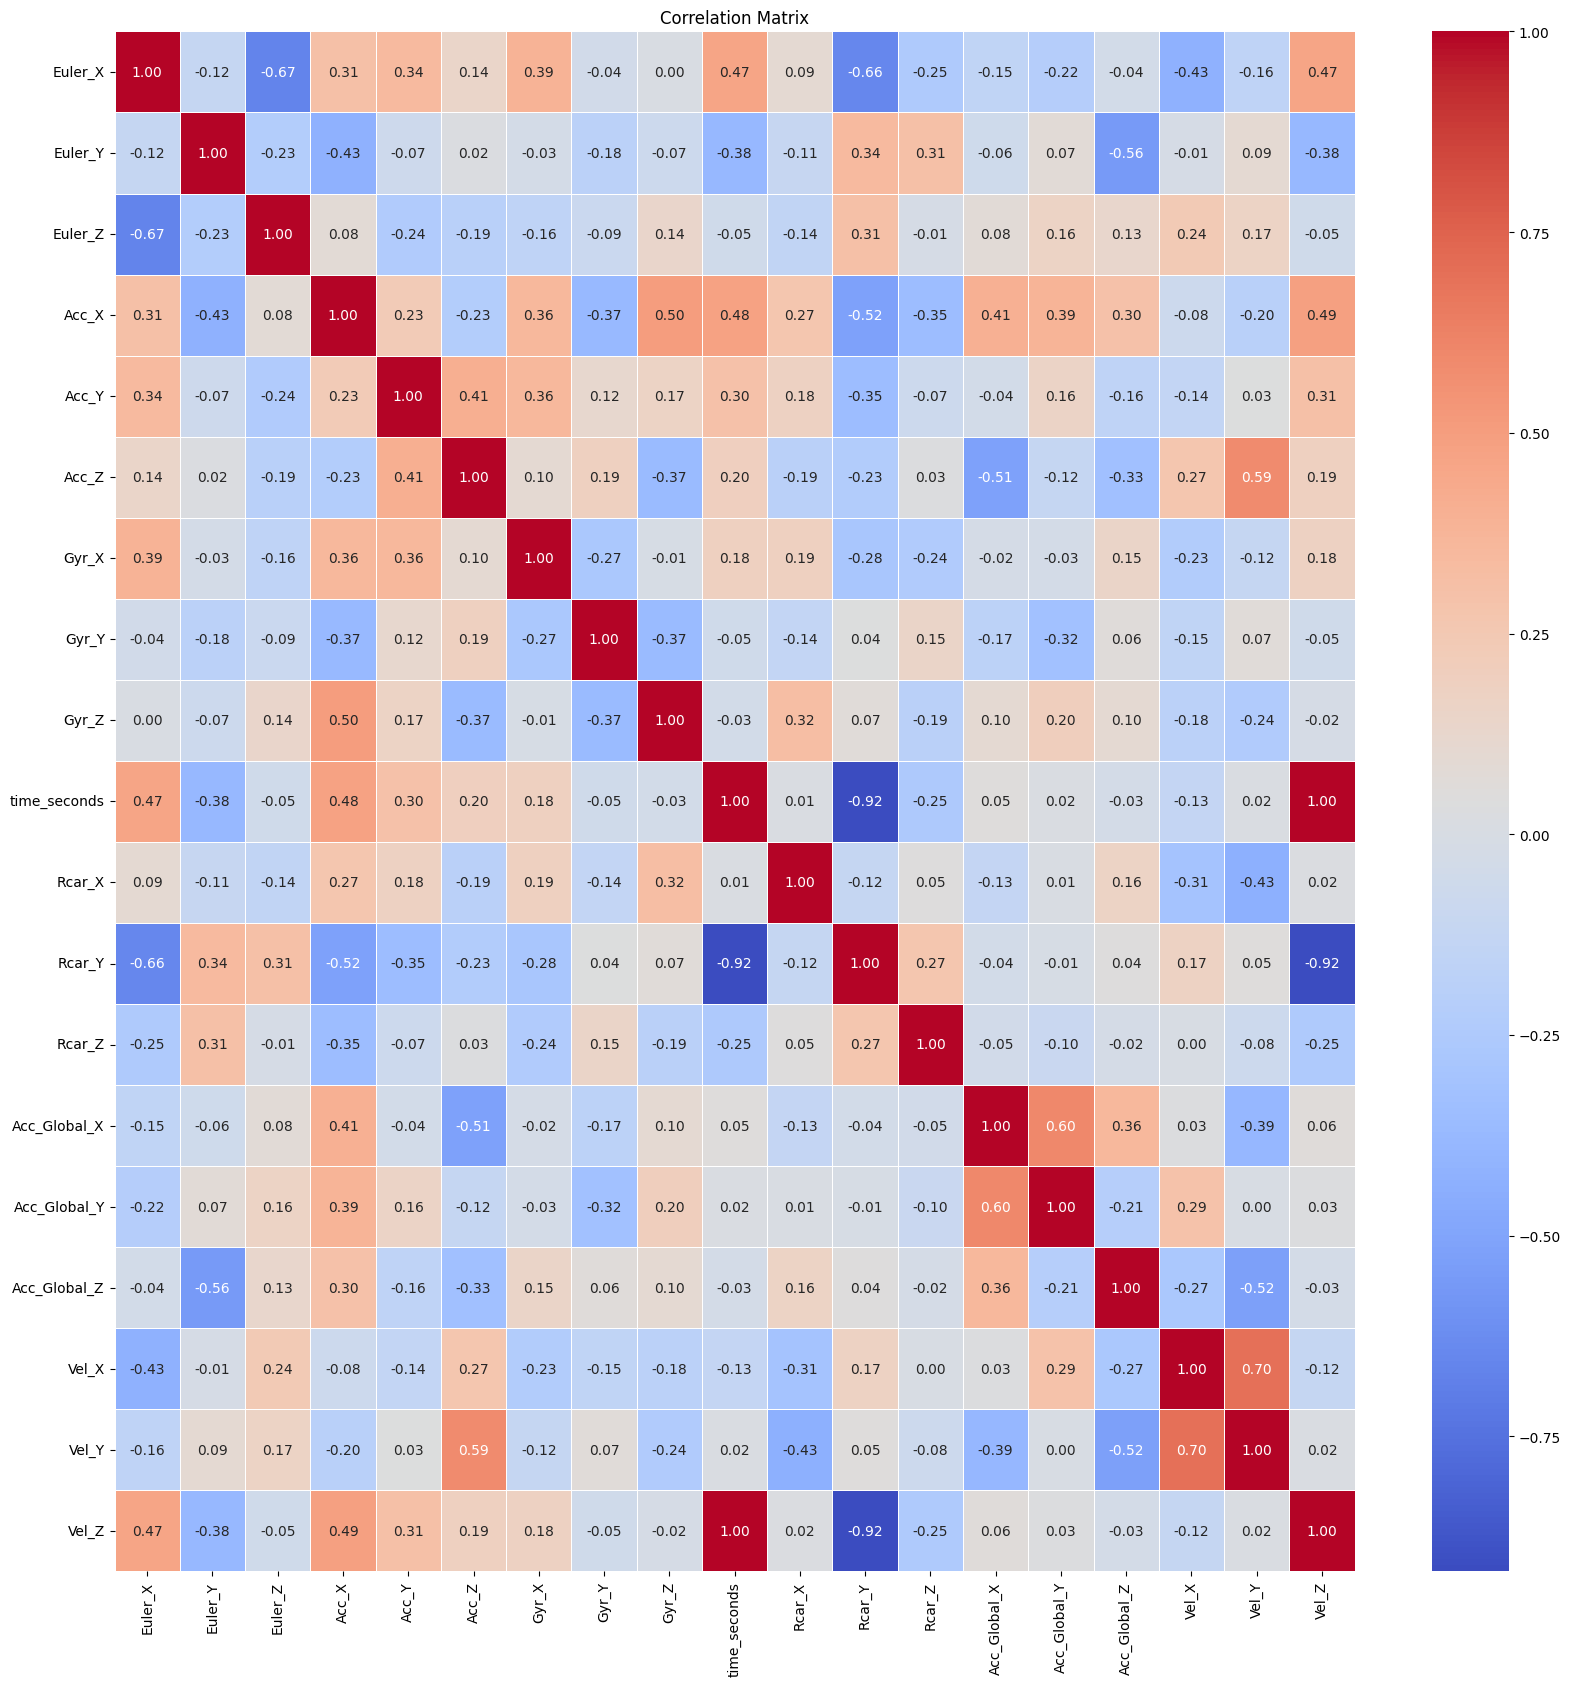

In [73]:
print(Bowling_arm2_filtered.dtypes)
print(Bowling_arm2_filtered.head())
corr_matrix = Bowling_arm2_filtered.corr()
print(corr_matrix)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()
correlation_threshold = 0.1 

# low_correlation_cols = [col for col in corr_matrix.columns if abs(corr_matrix.loc[col, 'Rcar_Z']) < correlation_threshold and col != 'Rcar_Z']

# Bowling_arm2_filtered = Bowling_arm2_filtered.drop(columns=low_correlation_cols)
# print(Bowling_arm2_filtered.head())
# corr_matrix_cleaned = Bowling_arm2_filtered.corr()
# print(corr_matrix_cleaned)
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix_cleaned, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Correlation Matrix (Filtered)')
# plt.show()

# Regression

In [98]:
X_train= Bowling_arm_filtered[['Acc_X','Vel_Z','time_seconds','Acc_Z', 'Euler_X','Euler_Z','Gyr_Z','Gyr_Y',]]
y_train = Bowling_arm_filtered['Rcar_Z']

X_test = Bowling_arm2_filtered[['Acc_X','Vel_Z','time_seconds','Acc_Z', 'Euler_X','Euler_Z','Gyr_Z','Gyr_Y',]]
y_test = Bowling_arm2_filtered['Rcar_Z']
# Print the shapes of the resulting datasets
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")


Training features shape: (1003, 8)
Testing features shape: (970, 8)
Training target shape: (1003,)
Testing target shape: (970,)


In [99]:
# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_regressor.predict(X_test)



Mean Squared Error: 85350.16
R-squared: -0.14
Root Mean Squared Error: 292.15


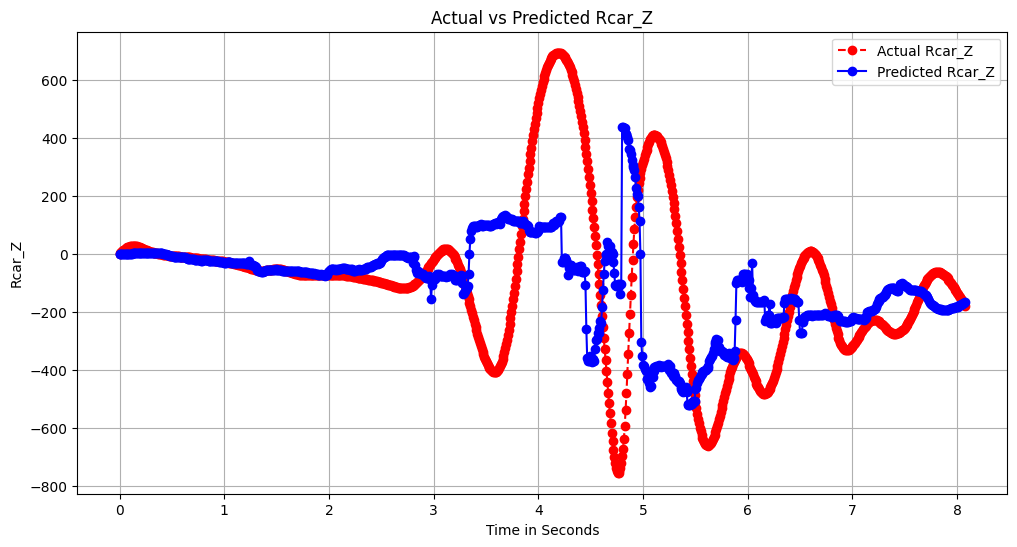

In [90]:
# Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")
rmse = math.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")
# Prepare data for plotting
plot_data = pd.DataFrame({
    'time_seconds': X_test['time_seconds'].values,
    'Actual Rcar_Z': y_test.values,
    'Predicted Rcar_Z': y_pred
})

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(plot_data['time_seconds'], plot_data['Actual Rcar_Z'], label='Actual Rcar_Z', color='red', marker='o', linestyle='--')
plt.plot(plot_data['time_seconds'], plot_data['Predicted Rcar_Z'], label='Predicted Rcar_Z', color='blue', marker='o', linestyle='-')
plt.xlabel('Time in Seconds')
plt.ylabel('Rcar_Z')
plt.title('Actual vs Predicted Rcar_Z')
plt.legend()
plt.grid(True)
plt.show()


In [100]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
dt_regressor = DecisionTreeRegressor()

# Fit the model
dt_regressor.fit(X_train, y_train)

# Make predictions
y_pred_train_dt = dt_regressor.predict(X_train)
y_pred_test_dt = dt_regressor.predict(X_test)

# Evaluate the model
print("Decision Tree Regressor:")
print(f"Training Mean Squared Error: {mean_squared_error(y_train, y_pred_train_dt)}")
print(f"Testing Mean Squared Error: {mean_squared_error(y_test, y_pred_test_dt)}")
print(f"Training R^2 Score: {r2_score(y_train, y_pred_train_dt)}")
print(f"Testing R^2 Score: {r2_score(y_test, y_pred_test_dt)}")


Decision Tree Regressor:
Training Mean Squared Error: 0.0
Testing Mean Squared Error: 81491.73228160363
Training R^2 Score: 1.0
Testing R^2 Score: -0.0912357101516037


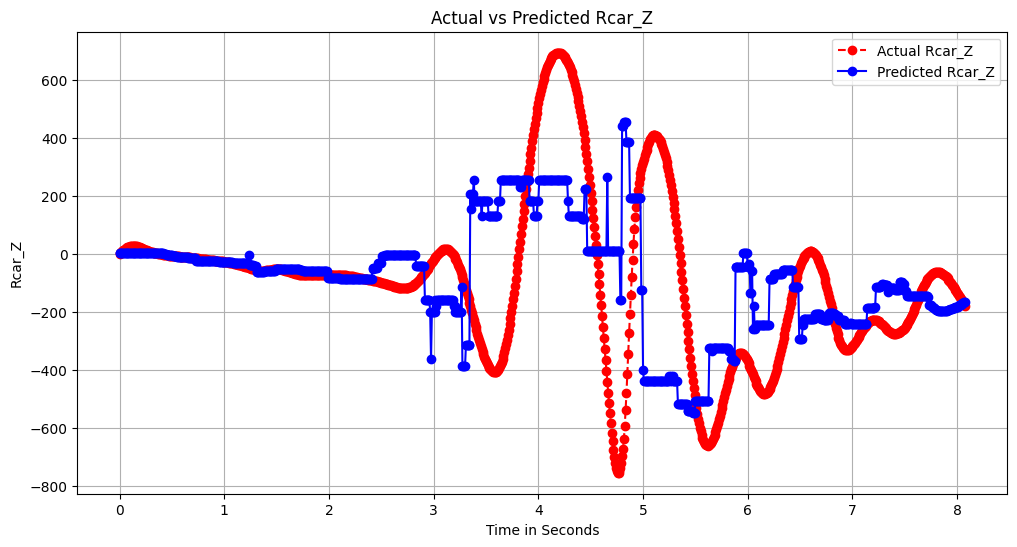

In [101]:
plot_data = pd.DataFrame({
    'time_seconds': X_test['time_seconds'].values,
    'Actual Rcar_Z': y_test.values,
    'Predicted Rcar_Z': y_pred_test_dt
})

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(plot_data['time_seconds'], plot_data['Actual Rcar_Z'], label='Actual Rcar_Z', color='red', marker='o', linestyle='--')
plt.plot(plot_data['time_seconds'], plot_data['Predicted Rcar_Z'], label='Predicted Rcar_Z', color='blue', marker='o', linestyle='-')
plt.xlabel('Time in Seconds')
plt.ylabel('Rcar_Z')
plt.title('Actual vs Predicted Rcar_Z')
plt.legend()
plt.grid(True)
plt.show()


In [93]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
gb_regressor = GradientBoostingRegressor()

# Fit the model
gb_regressor.fit(X_train, y_train)

# Make predictions
y_pred_train_gb = gb_regressor.predict(X_train)
y_pred_test_gb = gb_regressor.predict(X_test)

# Evaluate the model
print("Gradient Boosting Regressor:")
print(f"Training Mean Squared Error: {mean_squared_error(y_train, y_pred_train_gb)}")
print(f"Testing Mean Squared Error: {mean_squared_error(y_test, y_pred_test_gb)}")
print(f"Training R^2 Score: {r2_score(y_train, y_pred_train_gb)}")
print(f"Testing R^2 Score: {r2_score(y_test, y_pred_test_gb)}")


Gradient Boosting Regressor:
Training Mean Squared Error: 582.9092325612669
Testing Mean Squared Error: 100815.66403944157
Training R^2 Score: 0.9916346282276935
Testing R^2 Score: -0.3499977195517363


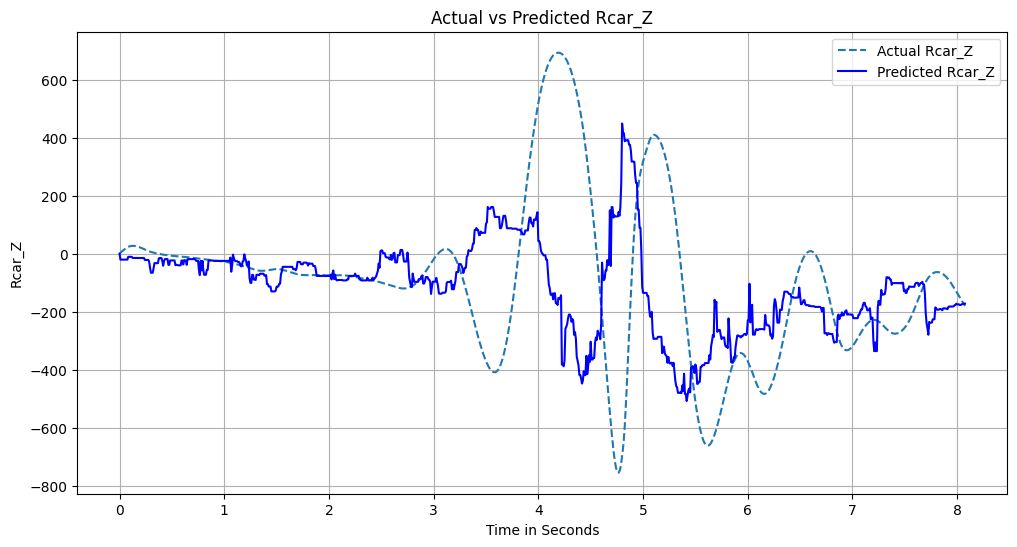

In [94]:
plot_data = pd.DataFrame({
    'time_seconds': X_test['time_seconds'].values,
    'Actual Rcar_Z': y_test.values,
    'Predicted Rcar_Z': y_pred_test_gb
})

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(plot_data['time_seconds'], plot_data['Actual Rcar_Z'], label='Actual Rcar_Z', linestyle='--')
plt.plot(plot_data['time_seconds'], plot_data['Predicted Rcar_Z'], label='Predicted Rcar_Z', color='blue', linestyle='-')
plt.xlabel('Time in Seconds')
plt.ylabel('Rcar_Z')
plt.title('Actual vs Predicted Rcar_Z')
plt.legend()
plt.grid(True)
plt.show()


Training model with basic architecture...


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


basic model RMSE: 1.5106825320518154
Training model with bidirectional architecture...


c:\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


bidirectional model RMSE: 1.5603412974974107
Training model with bidirectional_dropout architecture...
bidirectional_dropout model RMSE: 1.7266897439457773
Best model architecture: basic with RMSE: 1.5106825320518154
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test RMSE (unscaled): 386.7756042480469


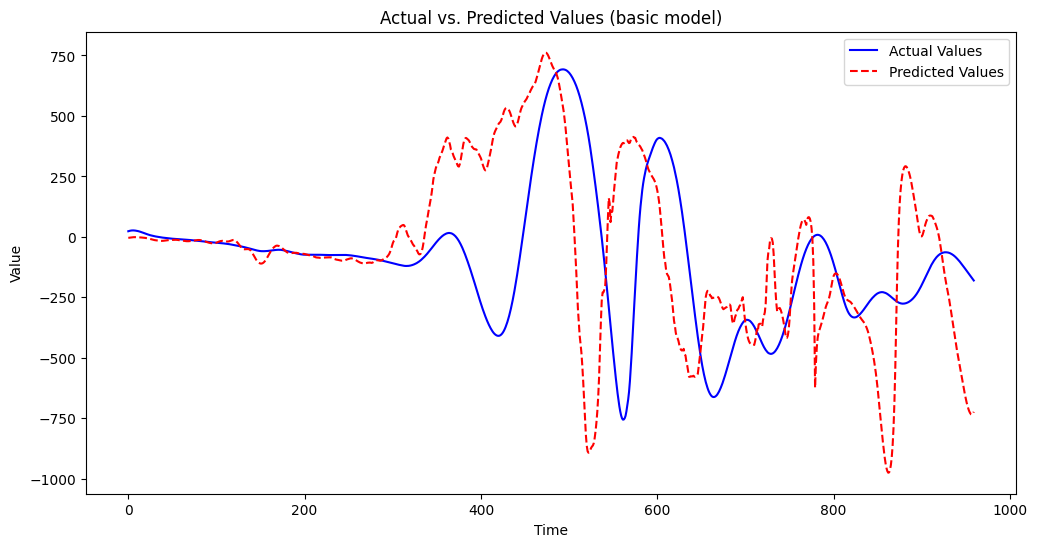

In [95]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)): 
        Xs.append(X.iloc[i-window_size:i].values)
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
window_size = 10
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)
X_train_seq = np.array(X_train_seq, dtype=np.float32)
y_train_seq = np.array(y_train_seq, dtype=np.float32)
X_test_seq = np.array(X_test_seq, dtype=np.float32)
y_test_seq = np.array(y_test_seq, dtype=np.float32)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_seq = scaler_X.fit_transform(X_train_seq.reshape(-1, X_train_seq.shape[-1])).reshape(X_train_seq.shape)
X_test_seq = scaler_X.transform(X_test_seq.reshape(-1, X_test_seq.shape[-1])).reshape(X_test_seq.shape)
y_train_seq = scaler_y.fit_transform(y_train_seq.reshape(-1, 1)).reshape(-1)
y_test_seq = scaler_y.transform(y_test_seq.reshape(-1, 1)).reshape(-1)


def build_model(architecture='basic'):
    model = Sequential()
    if architecture == 'basic':
        model.add(LSTM(100, input_shape=(window_size, X_train_seq.shape[2]), kernel_regularizer=l2(0.01)))
    elif architecture == 'bidirectional':
        model.add(Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(window_size, X_train_seq.shape[2])))
        model.add(Dropout(0.3))
        model.add(LSTM(100, kernel_regularizer=l2(0.01)))
    elif architecture == 'bidirectional_dropout':
        model.add(Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(window_size, X_train_seq.shape[2])))
        model.add(Dropout(0.4))
        model.add(LSTM(100, kernel_regularizer=l2(0.01)))
        model.add(Dropout(0.4))
    else:
        raise ValueError('Unknown architecture')
    
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


def evaluate_model(model):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    mse_test = model.evaluate(X_test_seq, y_test_seq, verbose=0)
    rmse_test = np.sqrt(mse_test)
    return rmse_test


architectures = ['basic', 'bidirectional', 'bidirectional_dropout']
results = {}

for arch in architectures:
    print(f"Training model with {arch} architecture...")
    model = build_model(architecture=arch)
    rmse_test = evaluate_model(model)
    results[arch] = rmse_test
    print(f"{arch} model RMSE: {rmse_test}")


best_architecture = min(results, key=results.get)
print(f"Best model architecture: {best_architecture} with RMSE: {results[best_architecture]}")

best_model = build_model(architecture=best_architecture)
best_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
y_pred_seq = best_model.predict(X_test_seq)


y_pred_seq = scaler_y.inverse_transform(y_pred_seq).reshape(-1)
y_test_seq = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).reshape(-1)

time_axis = np.arange(len(y_test_seq))
rmse_test_unscaled = np.sqrt(np.mean((y_test_seq - y_pred_seq) ** 2))
print(f'Test RMSE (unscaled): {rmse_test_unscaled}')

plt.figure(figsize=(12, 6))
plt.plot(time_axis, y_test_seq, label='Actual Values', color='blue')
plt.plot(time_axis, y_pred_seq, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Actual vs. Predicted Values ({best_architecture} model)')
plt.legend()
plt.show()


### Foot sensor 2 testing


In [82]:
data2 = pd.read_csv('foot_sensor2.csv')
data2['time_seconds'] = data2['time_seconds'] = data2.index * (1/120)
data2['Acc_Z_derivative'] = np.gradient(data2['Acc_Z'], data2['time_seconds'])
print(data2)

data2.to_csv('foot_sensor_updated2.csv', index=False)

      PacketCounter  SampleTimeFine    Euler_X    Euler_Y     Euler_Z  \
0                 0      2978585540  20.885427 -87.512421 -165.910751   
1                 1      2978593873  20.819683 -87.516045 -165.840408   
2                 2      2978602206  20.810535 -87.515724 -165.827118   
3                 3      2978610539  20.726240 -87.517937 -165.738953   
4                 4      2978618872  20.685238 -87.519508 -165.693100   
...             ...             ...        ...        ...         ...   
1683           1683      2992609979  18.526228 -87.212029 -167.660339   
1684           1684      2992618312  19.990259 -87.213371 -169.139221   
1685           1685      2992626645  21.448486 -87.214211 -170.613388   
1686           1686      2992634978  22.893452 -87.217094 -172.072403   
1687           1687      2992643311  24.267527 -87.221733 -173.460480   

         Acc_X     Acc_Y     Acc_Z     Gyr_X     Gyr_Y     Gyr_Z Unnamed: 11  \
0     0.000000  0.000000  0.000000  0.00000

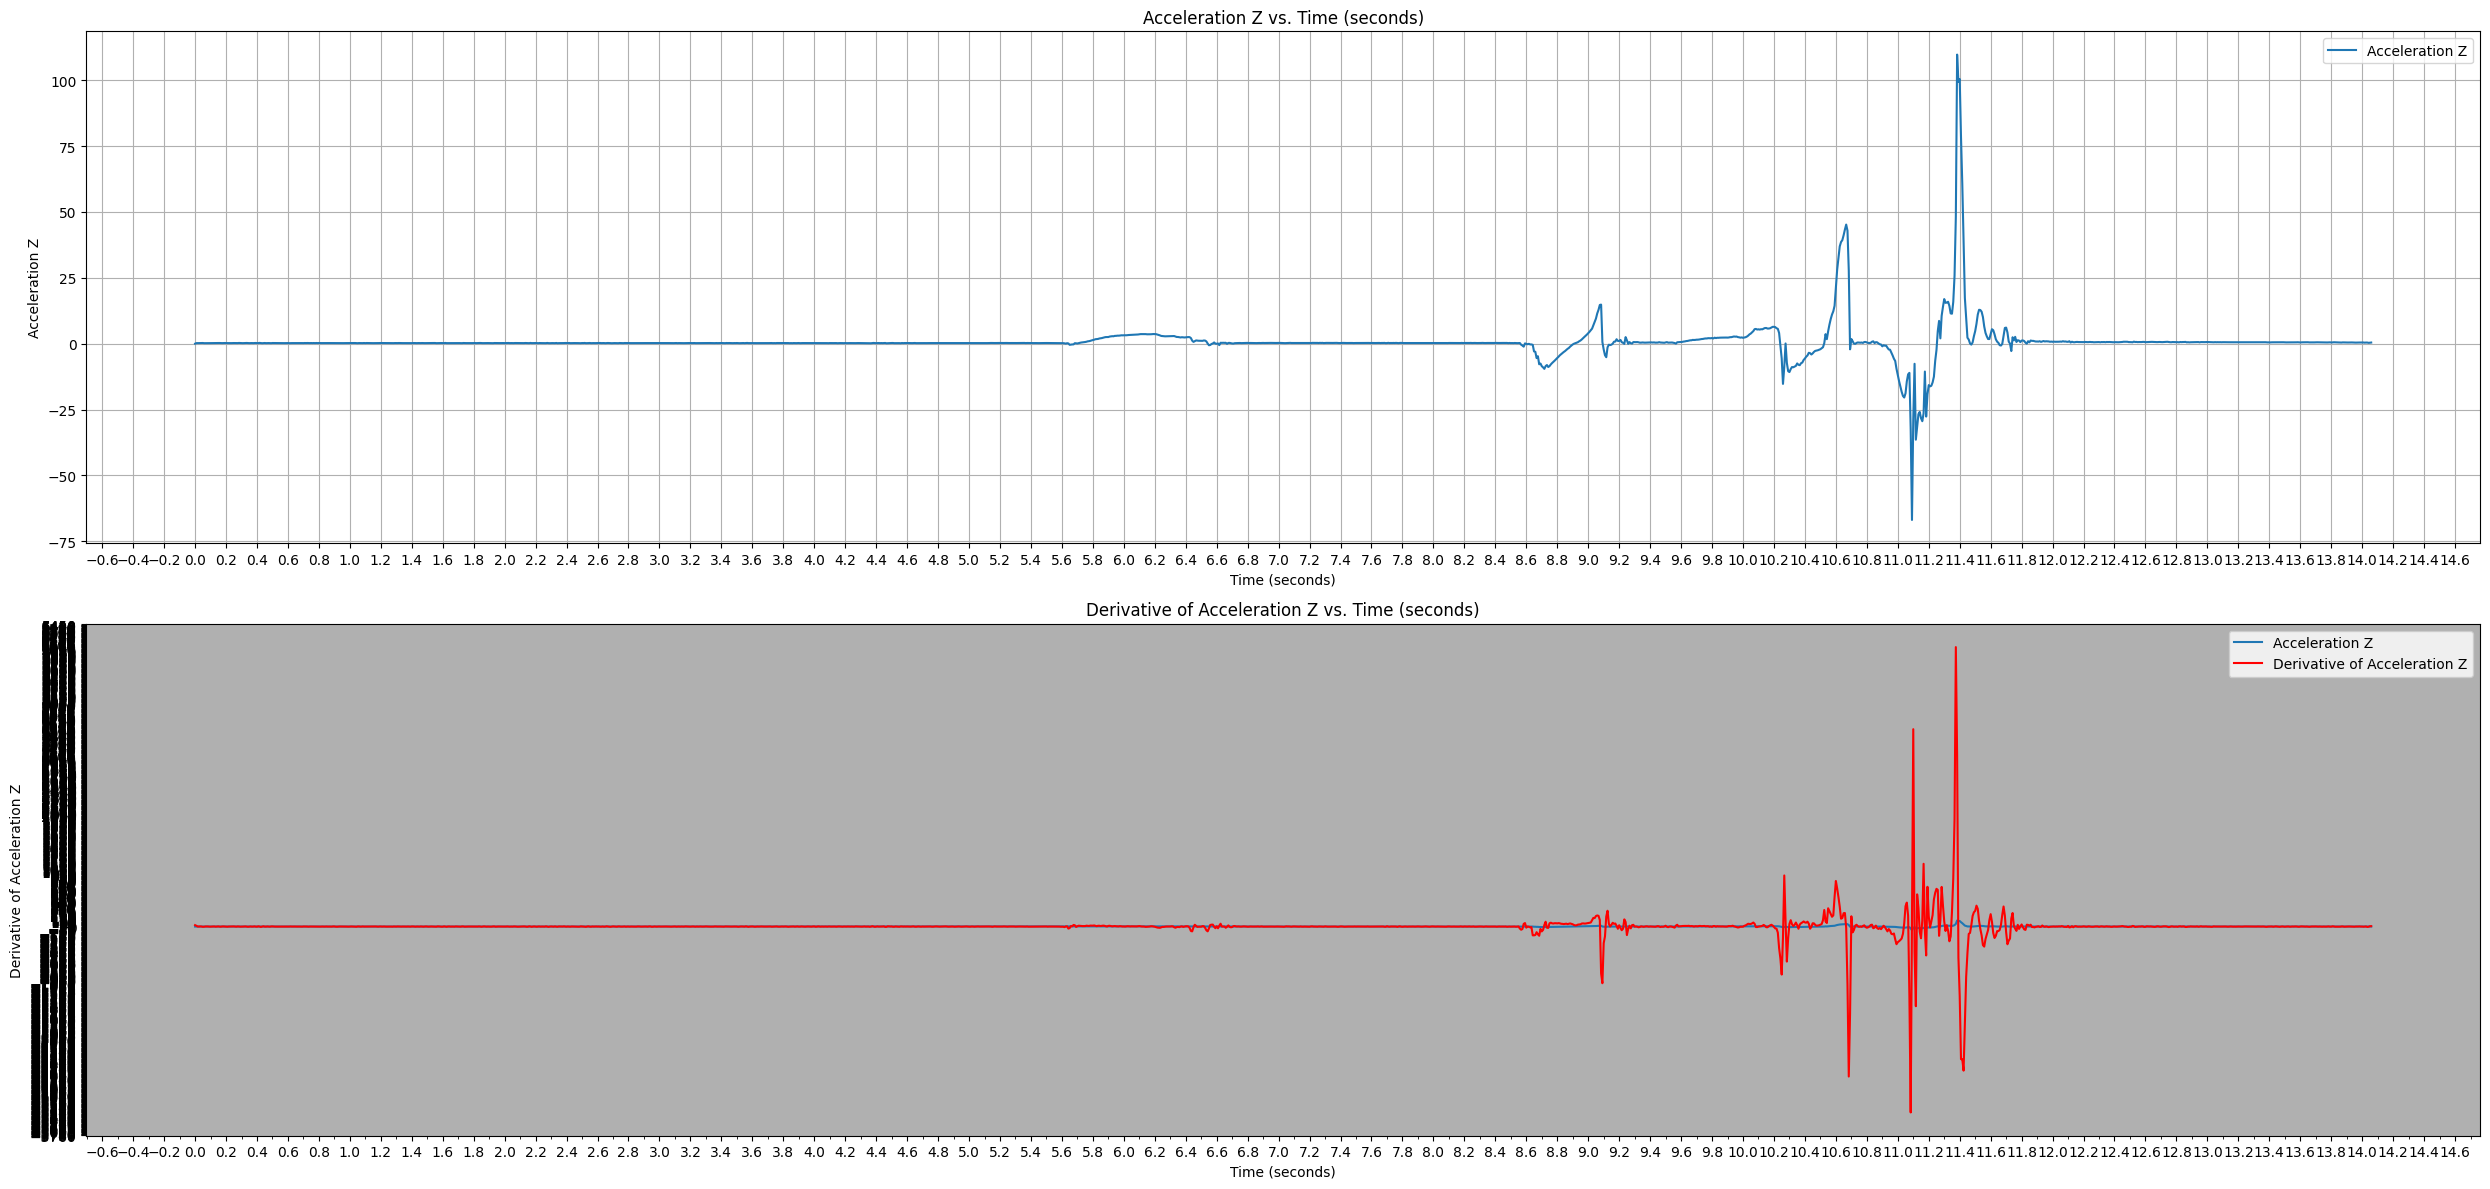

In [83]:


fig, axs = plt.subplots(2, 1, figsize=(25, 12))
data2['Acc_Z_derivative'] = np.gradient(data2['Acc_Z'], data2['time_seconds'])

# Plotting on the first subplot
axs[0].plot(data2['time_seconds'], data2['Acc_Z'], label='Acceleration Z')
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Acceleration Z')
axs[0].set_title('MultipleLocator(0.5)')
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(0.2))
axs[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
axs[0].set_title('Acceleration Z vs. Time (seconds)')
axs[0].legend()
axs[0].grid(True)

# Setting up the second subplot with specific x-axis locators
axs[1].plot(data2['time_seconds'], data2['Acc_Z'], label='Acceleration Z')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Acceleration Z')
axs[1].set_title('MultipleLocator(0.5)')
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(0.2))
axs[1].yaxis.set_major_locator(ticker.MultipleLocator(10))
axs[1].xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
axs[1].legend()
axs[1].grid(True)



axs[1].plot(data2['time_seconds'], data2['Acc_Z_derivative'], label='Derivative of Acceleration Z', color='red')
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Derivative of Acceleration Z')
axs[1].set_title('Derivative of Acceleration Z vs. Time (seconds)')

axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()


In [84]:
data2['change_in_gradient'] = np.gradient(data2['Acc_Z_derivative'], data2['time_seconds'])

# Define the threshold
threshold = 10

# Create a mask for points where the change in gradient exceeds the threshold
mask = np.abs(data2['change_in_gradient']) > threshold

In [85]:

# Compute the derivative of Acc_Z with respect to time
data2['Acc_Z_derivative'] = np.gradient(data2['Acc_Z'], data2['time_seconds'])

# Compute the change in the gradient (difference between consecutive values)
data2['change_in_gradient'] = np.diff(data2['Acc_Z_derivative'], prepend=data2['Acc_Z_derivative'][0])

# Define the threshold
threshold = 10

# Create a mask for points where the change in gradient exceeds the threshold
mask = np.abs(data2['change_in_gradient']) > threshold

# Skip the first 50 points for the mask and the corresponding results
skip_points = 50

# Adjust mask to skip the first 50 points
adjusted_mask = np.zeros_like(mask, dtype=bool)
adjusted_mask[skip_points:] = mask[skip_points:]

# Extract the points where the change in gradient is greater than the threshold
time_seconds_high_change = data2['time_seconds'][adjusted_mask]
acc_z_high_change = data2['Acc_Z'][adjusted_mask]
change_in_gradient_high_change = data2['change_in_gradient'][adjusted_mask]

top_10_count = 10
time_seconds_top_10 = time_seconds_high_change.head(top_10_count)
acc_z_top_10 = acc_z_high_change.head(top_10_count)
change_in_gradient_top_10 = change_in_gradient_high_change.head(top_10_count)

# Find the index of the maximum change in gradient among these 10 values
max_change_index = change_in_gradient_top_10.abs().idxmax()

# Retrieve the corresponding time for the maximum change in gradient
max_time = time_seconds_top_10.loc[max_change_index]
max_change = change_in_gradient_top_10.loc[max_change_index]

# Display the results
print("Top 10 changes in gradient (excluding the first 50 points):")
for t, acc, change in zip(time_seconds_top_10, acc_z_top_10, change_in_gradient_top_10):
    print(f"Time: {t:.2f} s, Acceleration Z: {acc:.2f}, Change in Gradient: {change:.2f}")

print(f"\nAbsolute maximum change in gradient: {max_change:.2f} at Time: {max_time:.2f} s")


Top 10 changes in gradient (excluding the first 50 points):
Time: 4.47 s, Acceleration Z: 0.19, Change in Gradient: 10.28
Time: 5.62 s, Acceleration Z: 0.03, Change in Gradient: 12.68
Time: 5.64 s, Acceleration Z: 0.10, Change in Gradient: -40.80
Time: 5.66 s, Acceleration Z: -0.35, Change in Gradient: 35.56
Time: 5.67 s, Acceleration Z: -0.27, Change in Gradient: 23.62
Time: 5.69 s, Acceleration Z: 0.13, Change in Gradient: -30.45
Time: 5.70 s, Acceleration Z: 0.08, Change in Gradient: 13.04
Time: 5.90 s, Acceleration Z: 2.53, Change in Gradient: 10.98
Time: 6.33 s, Acceleration Z: 2.90, Change in Gradient: -16.06
Time: 6.34 s, Acceleration Z: 2.55, Change in Gradient: 11.05

Absolute maximum change in gradient: -40.80 at Time: 5.64 s
